# **LDA and hSBM topic models**






## **Modules**


In [10]:
#Graph tool package
from topsbm import TopSBM
import graph_tool.all as gt

#Necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer

from datetime import datetime 
import logging 
import sys 
import pickle 
import requests
import io
import nltk
from nltk.tokenize import TweetTokenizer
import string
import re
from collections import defaultdict
import gensim

# remove infrequent words
from collections import Counter

#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('stopwords')

#Importing packages for data visualization 
import matplotlib.pyplot as plt
import seaborn as sns

#Importing packages for LDA
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore

## **Preprocessing**


In [7]:
#Read the twitter data
path = "data/final_df.csv"
df = pd.read_csv(path, index_col = 0)

#Subset bushfire period
df = df.loc[(df["created_at"] >= "2019-06-01") & (df["created_at"] <= "2020-06-01")] 
df = df.dropna(subset=["final_text"])

# Create dfm
vec = CountVectorizer(min_df = 10)
X = vec.fit_transform(df["final_text"])

X.shape

(50081, 10098)

# Modeling

## **hSBM**

In [66]:
#Note to self: docs is a list of docs, each containing list of words
## we create an instance of the sbmtm-class
model = TopSBM(random_state = 42)

## we have to create the word-document network from the corpus
model.fit_transform(X)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.05555556,
        0.        ],
       [0.        , 0.03571429, 0.        , ..., 0.        , 0.03571429,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.08333333,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [67]:
topics = pd.DataFrame(model.groups_[1]['p_w_tw'],index=vec.get_feature_names())#.transpose()

In [68]:
topics.shape[1]

80

In [ ]:
for topic in topics.columns:
    #if topic in [10, 59]:

    print(topics[topic].nlargest(10).to_markdown())
    print("-"*66)

## LDA

In [60]:
#Creating a corpus object 
#corpus = [id2word.doc2bow(doc) for doc in df['stems']]
corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)

In [61]:
n_topics = topics.shape[1] -1
#Running the LDA with 79 topics 
lda_model = LdaMulticore(corpus=corpus, num_topics=n_topics, passes = 100, iterations = 1000)

#Disabling logging
logging.disable(sys.maxsize)

In [106]:
#Insert the corpus of documents in bag of word format and get a list of (topic, probability) per document. 
document_topics = list(lda_model.get_document_topics(corpus)) 

#Creating a list of names for all 79 topics
topics = ['topic_{}'.format(t) for t in range(0,80)]

#Creating a dataframe of gamma probabilities 
gamma_probs = pd.DataFrame(np.zeros((len(document_topics),80)), columns = topics)

for i, doc in enumerate(document_topics): 
    for pair in doc: 
        gamma_probs.loc[i,'topic_{}'.format(pair[0])] = pair[1]

# Plotting

In [111]:
titles = df["party"]
#Create dataframe for document topic distribution
topic_dist = pd.DataFrame(model.groups_[1]['p_tw_d'], 
                          columns=titles).transpose().reset_index().rename(columns={"index":"party",
                                                                                    10:"hsb_bushfire1",
                                                                                    59:"hsb_bushfire2" })

topic_dist["created_at"] = df["created_at"].tolist()
topic_dist["user_id"] = df["user_id"].tolist()
topic_dist['created_at'] = pd.to_datetime(topic_dist['created_at'], format = '%Y-%m-%d')
topic_dist["lda_bushfire1"], topic_dist["lda_bushfire2"] = gamma_probs["topic_40"], gamma_probs["topic_41"]
topic_dist["hsb_bushfire_combined"] = topic_dist["hsb_bushfire1"] + topic_dist["hsb_bushfire2"]

In [112]:
#Aggregate the data by week
topic_week = topic_dist.groupby("party").resample('W-Mon', on='created_at').agg({"party":"first", "created_at":"first",
                                                                                 "hsb_bushfire1":"mean", "hsb_bushfire2":"mean",
                                                                                 "hsb_bushfire_combined" :"mean",
                                                                                 "lda_bushfire1":"mean", "lda_bushfire2":"mean"}).reset_index(drop = True)

In [ ]:
parties = ["Liberal Party of Australia", "Australian Greens", "Australian Labor Party", "Centre Alliance", "The Nationals"]
markers = ["bo-", "g^-", "r*-", "y+-", "c*-"]

fig, ax = plt.subplots(figsize=(18, 8), dpi=600)
for marker, party in zip(markers, parties):
    temp = topic_week.loc[topic_week["party"] == party]
    ax.plot(temp["created_at"], temp[outcome], marker, label = party)

ax.set_ylabel("Bushfire Topic Proportion")
plt.legend()
plt.savefig
plt.show()

In [147]:
def plot_series(outcome, fig_name = None):
    parties = ["Liberal Party of Australia", "Australian Greens", "Australian Labor Party", 
               "Centre Alliance", "The Nationals", "Liberal National Party of Queensland"]
    markers = ["bo-", "g^-", "r*-", "y+-", "c*-", ]

    fig, ax = plt.subplots(figsize=(18, 8), dpi=600)
    for marker, party in zip(markers, parties):
        temp = topic_week.loc[topic_week["party"] == party]
        ax.plot(temp["created_at"], temp[outcome], marker, label = party)

    ax.set_ylabel("Bushfire Topic Proportion")
    plt.legend()
    if fig_name:
        plt.savefig(fig_name)
    plt.show()
    
    
    return 


In [122]:
import statsmodels.api as sm

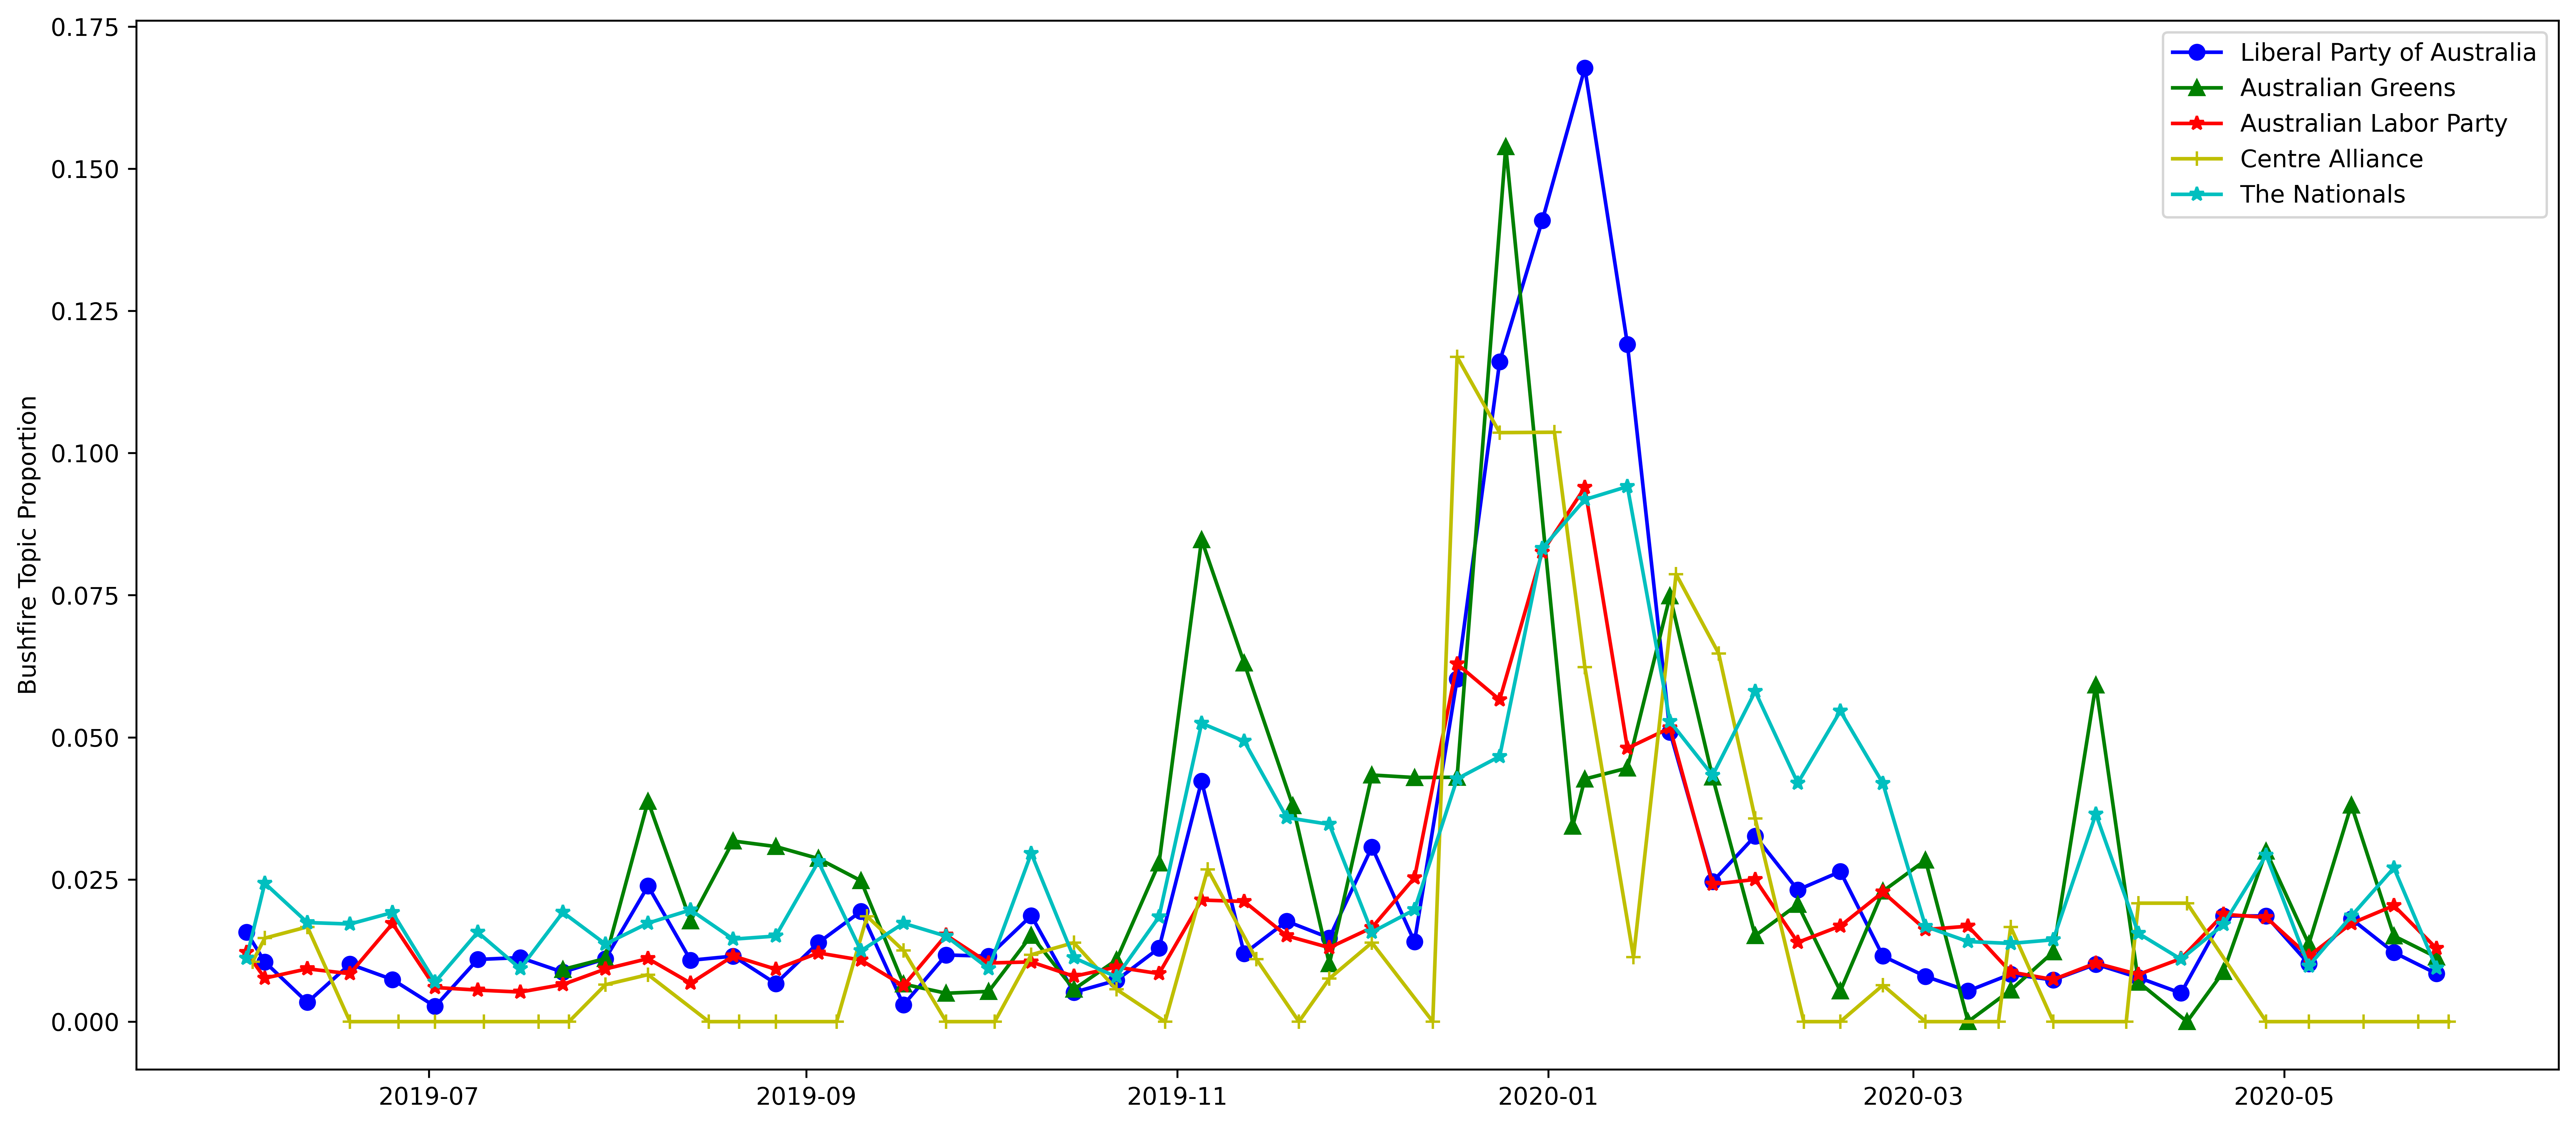

In [118]:
hsb_fig = plot_series("hsb_bushfire_combined")

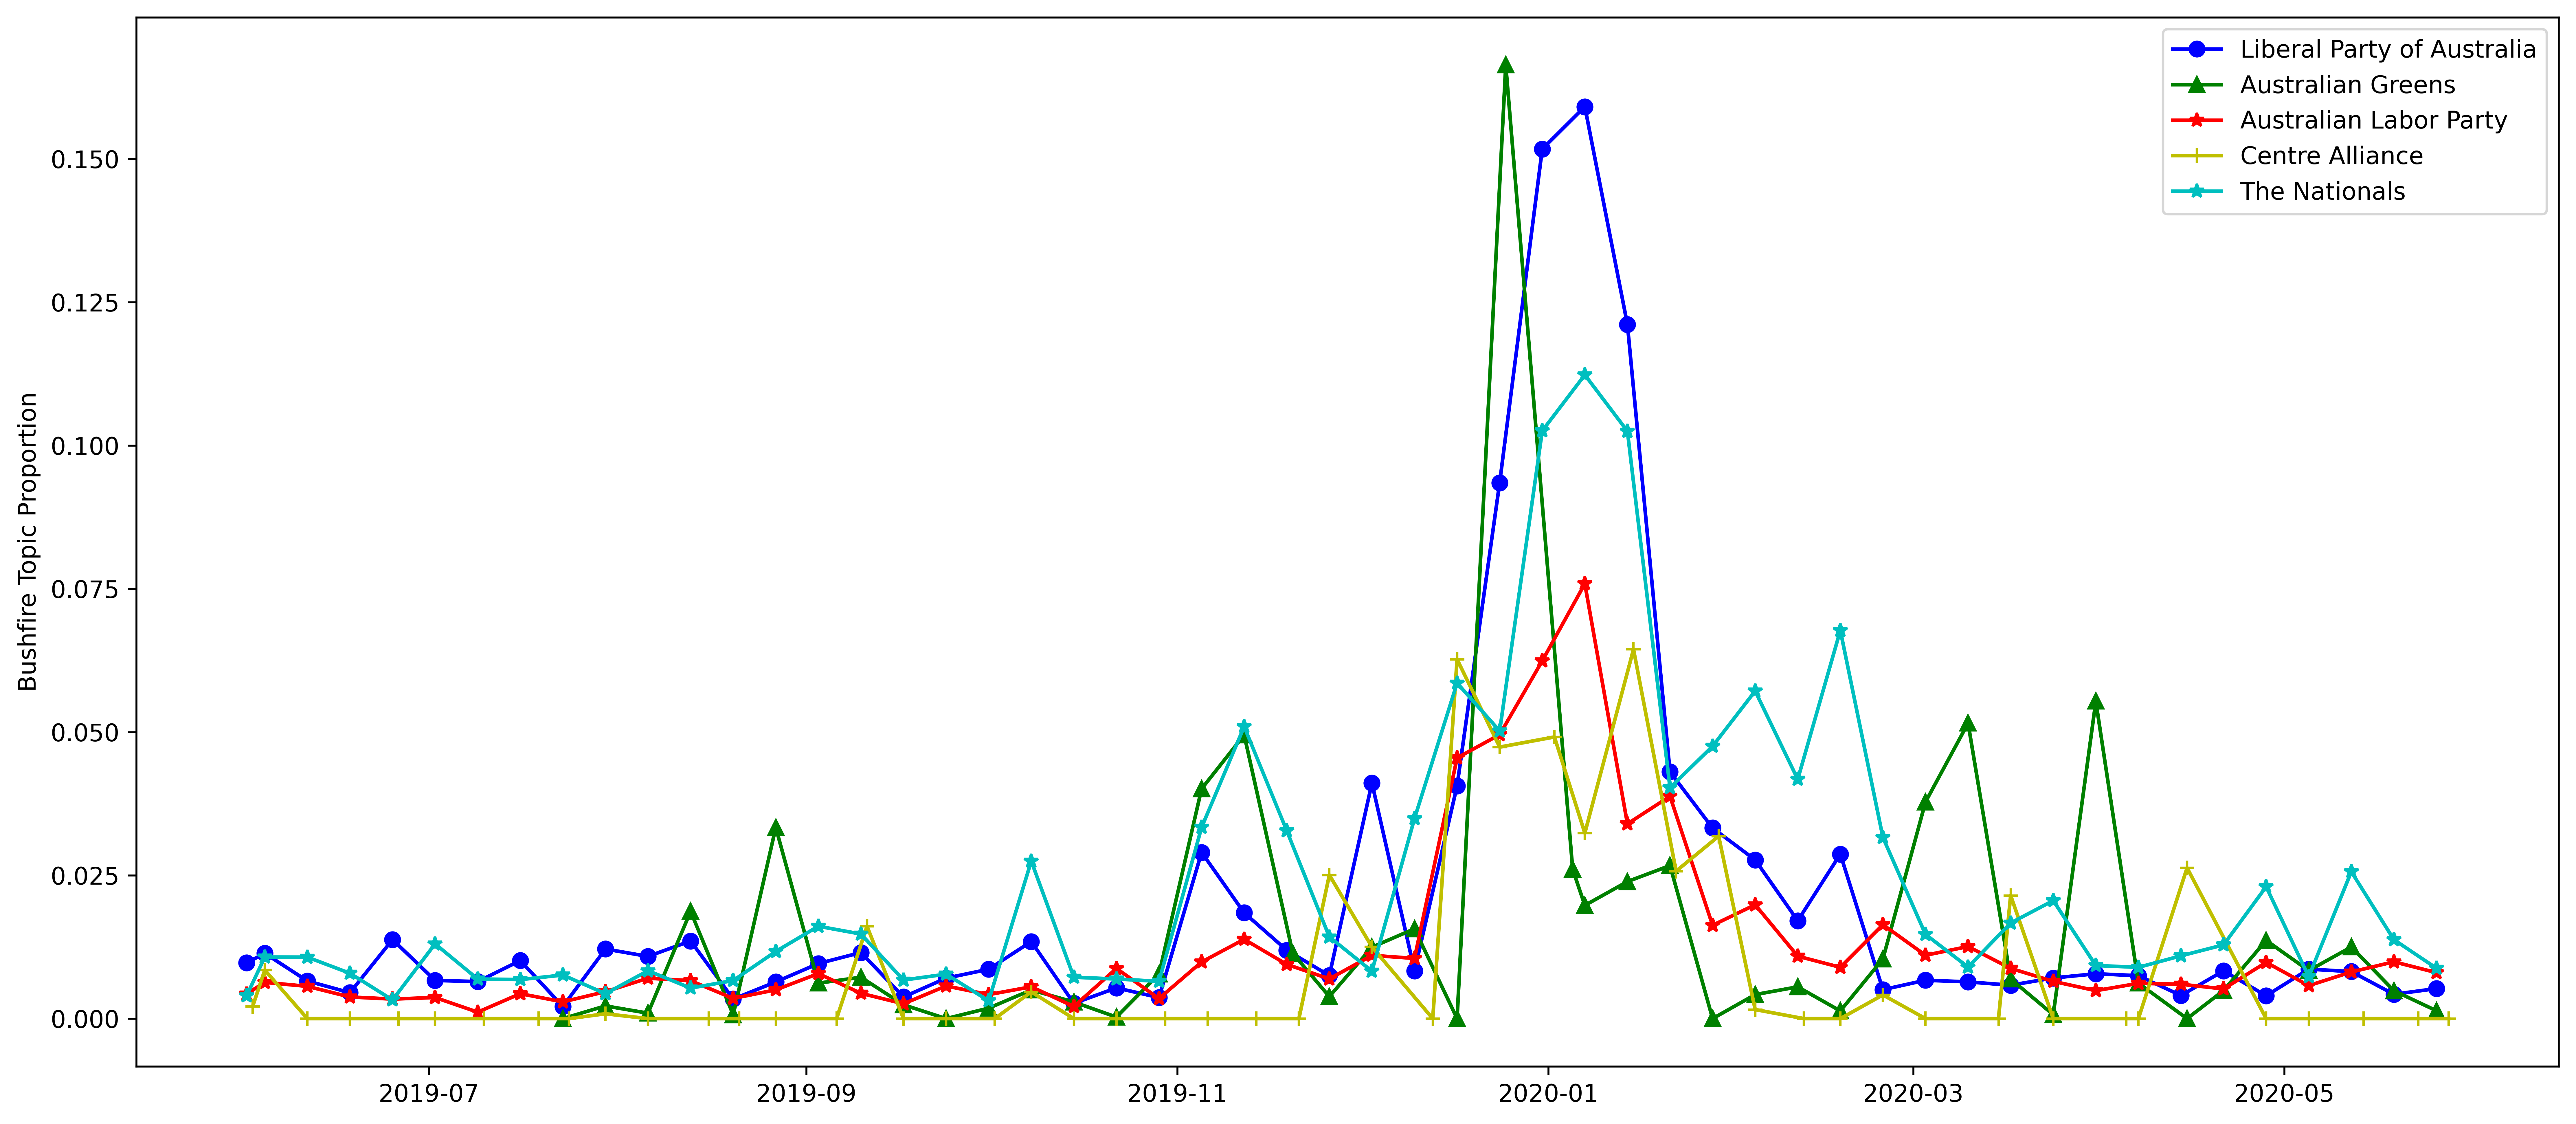

In [148]:
plot_series("lda_bushfire1", fig_name="lda_topicprop.png")

In [150]:
#Evaluate correlation between LDA and hSBM
import scipy.stats as stats

corr_df = topic_week.dropna(subset=["lda_bushfire1", "hsb_bushfire_combined"])
corrs = {}
for party in corr_df["party"].unique():
    temp = corr_df.loc[corr_df["party"]==party]
    corrs[party] = np.round(stats.pearsonr(temp["lda_bushfire1"], temp["hsb_bushfire_combined"]), 3)

corrs = pd.DataFrame(corrs)
print(corrs.transpose().to_markdown())

|                                      |      0 |     1 |
|:-------------------------------------|-------:|------:|
| Australian Greens                    |  0.8   | 0     |
| Australian Labor Party               |  0.982 | 0     |
| Centre Alliance                      |  0.788 | 0     |
| Independent                          | -0.084 | 0.893 |
| Katter's Australian Party            |  0.155 | 0.54  |
| Liberal National Party of Queensland |  0.899 | 0     |
| Liberal Party of Australia           |  0.981 | 0     |
| The Nationals                        |  0.937 | 0     |


# **LDA**
unique

In [94]:
#Creating a dataframe with tokens as columns and topics as rows 
beta_df = pd.DataFrame(lda_model.get_topics(), columns = list(vec.get_feature_names())).transpose()

In [ ]:
topic_dist

In [ ]:
for col in beta_df.columns:
    if col in [40, 41]:
        print("-"*66)
        print(beta_df[col].nlargest(20).to_markdown())